##Fine tuning roberta academic




In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes


import json
import torch
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from huggingface_hub import HfFolder, notebook_login

! pip install transformers[torch] -U
! pip install accelerate -U


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
import  argparse
import pandas as pd
import json
import numpy as np


In [4]:
with open("/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_chatGPT_train.jsonl", "r") as file:
    train_data = [json.loads(line) for line in file]

with open("/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_chatGPT_val.jsonl", "r") as file:
    val_data = [json.loads(line) for line in file]


In [5]:
# Create a list to store examples and labels
train_examples = []
train_labels = []

# Iterate through each line in the data
for example in train_data:
    # Append the human-generated text and assign label 0
    train_examples.append(example["human_text"])
    train_labels.append(0)
    # Append the machine-generated text and assign label 1
    train_examples.append(example["machine_text"])
    train_labels.append(1)


In [6]:
# Create a list to store examples and labels
val_examples = []
val_labels = []

# Iterate through each line in the data
for example in val_data:
    # Append the human-generated text and assign label 0
    val_examples.append(example["human_text"])
    val_labels.append(0)
    # Append the machine-generated text and assign label 1
    val_examples.append(example["machine_text"])
    val_labels.append(1)


In [9]:
#print(val_examples)

In [7]:
from datasets import Dataset
# Create a Dataset object with the text and corresponding labels
train_dataset = Dataset.from_dict({"text": train_examples, "labels": train_labels})
val_dataset = Dataset.from_dict({"text": val_examples, "labels": val_labels})


In [8]:
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig
)
from sklearn.metrics import accuracy_score


In [9]:
# Load the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("andreas122001/roberta-academic-detector")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


In [11]:
train_data = train_dataset.map(tokenize_function, batched=True)
val_data = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

In [12]:
model_id = "roberta-base"
dataset_id = "ag_news"
# relace the value with your model: ex <hugging-face-user>/<model-name>
repository_id = "egumasa/roberta-base-academic"

In [13]:
notebook_login()


In [14]:
# Define the model
model = RobertaForSequenceClassification.from_pretrained("andreas122001/roberta-academic-detector", num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:

# TrainingArguments
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)


In [16]:
# Fine-tune the model
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.000000,0.000002
2,0.003000,0.021381
3,0.000200,0.000127


TrainOutput(global_step=1440, training_loss=0.018358225090634683, metrics={'train_runtime': 1238.3737, 'train_samples_per_second': 9.303, 'train_steps_per_second': 1.163, 'total_flos': 3031039357747200.0, 'train_loss': 0.018358225090634683, 'epoch': 3.0})

##Saving the model

In [17]:
import os

# Define the directory in Google Drive where you want to save the model
output_dir = "/content/drive/MyDrive/Marcus_Project/roberta_academic_finetuned/model_without_n"

# Make sure the directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model and tokenizer
model_path = os.path.join(output_dir, "model")
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


trainer.model.config.save_pretrained(model_path)


In [18]:
from transformers import pipeline

# Load the tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Marcus_Project/roberta_academic_finetuned/model_without_n/model")
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Marcus_Project/roberta_academic_finetuned/model_without_n/model")
classifier = pipeline('text-classification',"/content/drive/MyDrive/Marcus_Project/roberta_academic_finetuned/model_without_n/model")


## Test =  machine_generated abstracts


In [19]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_chatGPT_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count, end=" ")  # Print count without newline
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [20]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human_text')

print(true_labels)

['machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated'

The accuracy is 0.5591666666666667
The precision is 0.7589004631036452
The recall is 0.5591666666666666


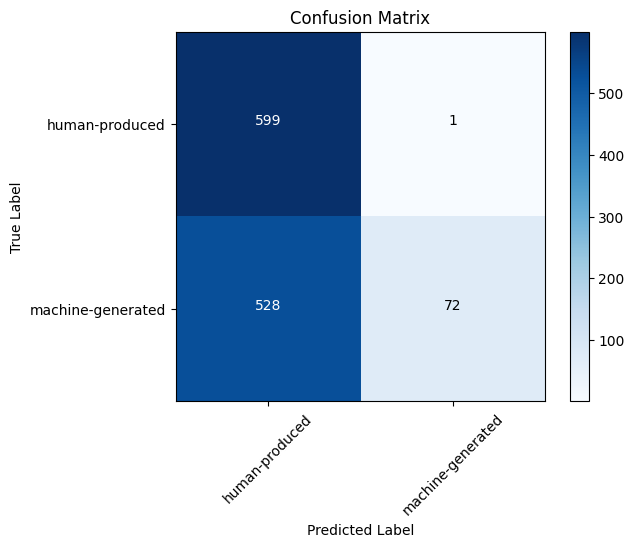

In [21]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing cohere dataset


In [23]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_cohere_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count, end=" ")  # Print count without newline

            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

The accuracy is 0.5016666666666667
The precision is 0.6254180602006689
The recall is 0.5016666666666666


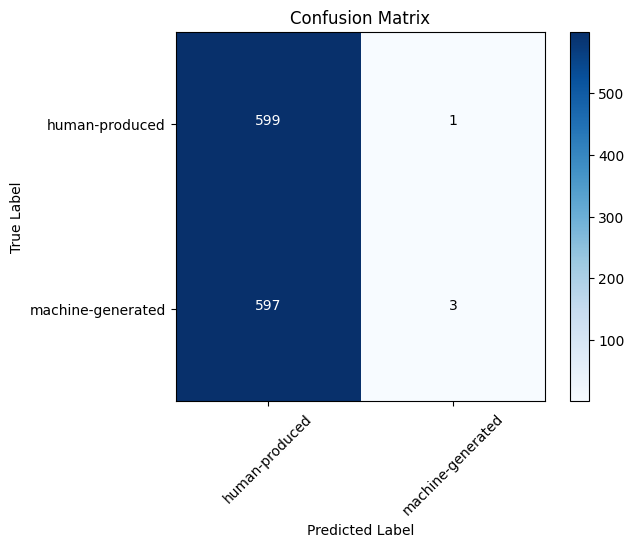

In [24]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing Davinci Dataset

In [25]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_davinci_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count, end=" ")  # Print count without newline
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

The accuracy is 0.5183333333333333
The precision is 0.7546689303904923
The recall is 0.5183333333333333


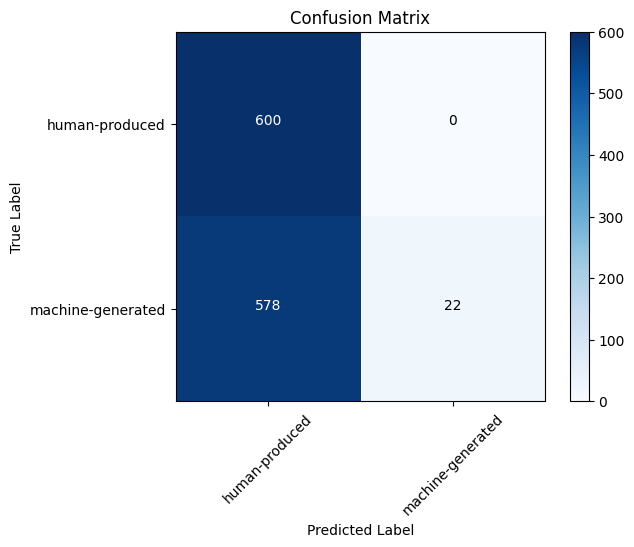

In [26]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing flant5 dataset

In [28]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_flant5_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count, end=" ")  # Print count without newline
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

The accuracy is 0.7825
The precision is 0.847194958333191
The recall is 0.7825


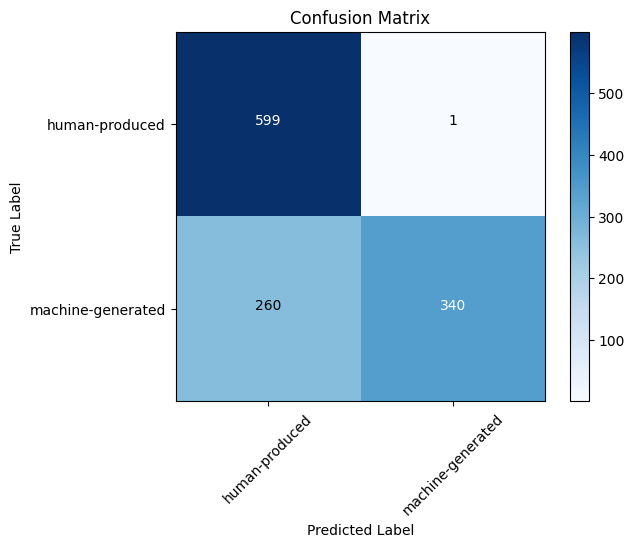

In [29]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing Bloomz dataset

In [30]:
import json
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_bloomz_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_abstract']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['abstract']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count, end=" ")  # Print count without newline

            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

The accuracy is 0.505
The precision is 0.688758389261745
The recall is 0.505


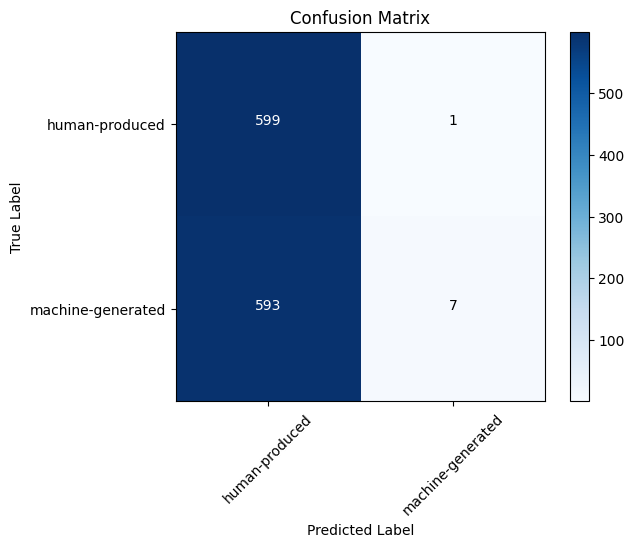

In [31]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()

